In [ ]:
#IMPORTS
import string
from collections import Counter
import datetime as dt
from numpy import array
import numpy as np
import pickle
from pickle import load, dump
# from keras.applications.inception_v3 import InceptionV3
from keras.applications import ResNet152V2
from keras.models import Model
from keras.preprocessing import image
# from keras.applications.inception_v3 import preprocess_input
from keras.applications.resnet_v2 import preprocess_input
from keras import Input
from keras.layers import Dropout, Dense, Embedding, LSTM
from keras.layers.merge import add
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#RUN THIS CELL ONLY ONCE
import wandb
wandb.init(project="model5")

W&B Run: https://app.wandb.ai/vipul43/model5/runs/v1szhg3n

In [3]:
#EXTRACTING TEXT DATA AND PREPROCESSING
#STEP: EXTRACTING DATA
filepath = "../../../Downloads/Flickr8k/Flickr8k_text/Flickr8k.token.txt"
file = open(filepath, 'r')
content = file.read()
file.close()
lines = content.split('\n')

#STEP: SAVING DATA IN A DICTIONARY FOR TIME EFFICIENCY PURPOSES
tokens_dic = {}
for line in lines:
    tokens = line.split()
    image_ = tokens[0]
    caption = ' '.join(tokens[1:])
    image_title = image_.split('.')[0]
    if(image_title not in tokens_dic.keys()):
        tokens_dic[image_title] = [caption]
    else:
        tokens_dic[image_title].append(caption)


#STEP: PREPROCESSING
table = str.maketrans('', '', string.punctuation)
for captions in tokens_dic.values():
    for i in range(len(captions)):
        caption = captions[i]
        words = caption.split()
        words = [word.lower() for word in words]
        words = [word.translate(table) for word in words]
        words = [word for word in words if len(word)>1]
        words = [word for word in words if word.isalpha()]
        captions[i] = ' '.join(words)
        

#LOADING TRAINING SET

#STEP: EXTRACTING DATA
filepath = "../../../Downloads/Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt"
file = open(filepath, "r")
content = file.read()
file.close()
lines = content.split('\n')

#STEP: SAVING DATA IN A LIST
train = []
for line in lines:
    [image_title, stuff] =  line.split('.')
    train.append(image_title)
#NOTE: SIZE OF TRAIN LIST IS 6000

#STEP: SAVING IMAGE-CAPTIONS IN TRAIN DATASET
train_dataset = {}
max_caption_length = 0
for image_title, captions in tokens_dic.items():
    if(image_title in train and (image_title not in train_dataset.keys())):
        train_dataset[image_title] = list()
        for caption in captions:
            refined_caption = "startseq " + caption + " endseq"
            train_dataset[image_title].append(refined_caption)
            max_caption_length = max(max_caption_length, len(refined_caption.split()))
#NOTE: SIZE OF TRAIN DATASET IS 6000


#LOADING CROSS VALIDATION(OR DEVELOPMENT) SET

#STEP: EXTRACTING DATA
filepath = "../../../Downloads/Flickr8k/Flickr8k_text/Flickr_8k.devImages.txt"
file = open(filepath, "r")
content = file.read()
file.close()
lines = content.split('\n')

#STEP: SAVING DATA IN A LIST
dev = []
for line in lines:
    [image_title, stuff] =  line.split('.')
    dev.append(image_title)
#NOTE: SIZE OF TEST LIST IS 1000

#STEP: SAVING IMAGE-CAPTIONS IN TRAIN DATASET
dev_dataset = {}
for image_title, captions in tokens_dic.items():
    if(image_title in dev and (image_title not in dev_dataset.keys())):
        dev_dataset[image_title] = list()
        for caption in captions:
            refined_caption = "startseq " + caption + " endseq"
            dev_dataset[image_title].append(refined_caption)
#NOTE: SIZE OF DEV DATASET IS 1000


#LOADING TESTING SET

#STEP: EXTRACTING DATA
filepath = "../../../Downloads/Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt"
file = open(filepath, "r")
content = file.read()
file.close()
lines = content.split('\n')

#STEP: SAVING DATA IN A LIST
test = []
for line in lines:
    [image_title, stuff] =  line.split('.')
    test.append(image_title)
#NOTE: SIZE OF TEST LIST IS 1000

#STEP: SAVING IMAGE-CAPTIONS IN TRAIN DATASET
test_dataset = {}
for image_title, captions in tokens_dic.items():
    if(image_title in test and (image_title not in test_dataset.keys())):
        test_dataset[image_title] = list()
        for caption in captions:
            refined_caption = "startseq " + caption + " endseq"
            test_dataset[image_title].append(refined_caption)
#NOTE: SIZE OF TEST DATASET IS 1000


#CONSTRUCTING VOCABULARY FROM CAPTIONS
vocabulary = set()
for captions in tokens_dic.values():
    for caption in captions:
        for word in caption.split():
            vocabulary.add(word)
#NOTE: SIZE OF VOCABULARY BY NOT LETTING 1 LENGTH WORDS BE IN CAPTION IS 8763

#CONSTRUCTING MOST PROBABLE VOCABULARY FROM ALL TRAIN WORDS
word_count_threshold = 10
all_train_words = []
for captions in train_dataset.values():
    for caption in captions:
        words = caption.split()
        for word in words:
            all_train_words.append(word)

counter = Counter(all_train_words)
commons = counter.most_common()
most_probable_vocabulary = set()
for ele in commons:
    if(ele[1]>=word_count_threshold):
        most_probable_vocabulary.add(ele[0])
vocabulary_size = len(most_probable_vocabulary)
#NOTE: SIZE OF MOST PROBABLE VOCABULARY BY NOT LETTING 1 LENGTH WORDS BE IN CAPTION IS 1651


#READING ENCODED TRAIN IMAGES, ENCODED DEV IMAGES AND ENCODED TEST IMAGES FROM PKL FILES
encoded_train_images = {}
encoded_dev_images = {}
encoded_test_images = {}
with open("encoded_train_images2.pkl", "rb") as encoded_pickle:
    encoded_train_images = load(encoded_pickle)
    
with open("encoded_test_images2.pkl", "rb") as encoded_pickle:
    encoded_test_images = load(encoded_pickle)
    
with open("encoded_dev_images2.pkl", "rb") as encoded_pickle:
    encoded_dev_images = load(encoded_pickle)


def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key]
            for desc in desc_list:
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocabulary_size+1)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0
                
                
#USEFUL DICTIONARIES
index_to_word = {}
word_to_index = {}
index = 1
for word in most_probable_vocabulary:
    index_to_word[index] = word
    word_to_index[word] = index
    index+=1


#WORD EMBEDDINGS, MAPPING EVERY WORD OF OUR MOST PROBABALE VOCABULARY TO 200 DIMENSION VECTOR, FOR THAT WE WILL BE USING GLOVE
embeddings = {}
file = open("../../../Downloads/glove/glove.6B.200d.txt", "r")
content = file.read()
file.close()
lines = content.split('\n')
for line in lines:
    word_and_vector = line.split()
    word = word_and_vector[0]
    vector = word_and_vector[1:]
    vector = np.asarray(vector, dtype='float32')
    embeddings[word] = vector
    
    
#MAPPING MOST PROBABLE VOCABULARY TO VECTOR BY CREATING A DENSE MATRIX WITH ROW AS WORD AND COLUMNS ARE 200 DIMENSIONS OF VECTOR
embedding_dim = 200
embeddings_matrix = np.zeros((vocabulary_size+1, embedding_dim))
for word, index in word_to_index.items():
    vector = embeddings.get(word)
    if(vector is not None):
        embeddings_matrix[index]=vector
#NOTE: DIMENSION OF EMBEDDINGS MATRIX IS (MOST PROBABLE VOCABULARY X 200), HERE (1951 X 200)
#NOTE: 1ST ROW OF EMBEDDINGS MATRIX IS ALL ZEROS

# model
<img src="files/images/model1_arch.png?1">
<img src="files/images/model_summary.png?1">
<img src="files/images/model_performance.png?1">

# model2
<img src="files/images/model2_arch.png?1">
<img src="files/images/model2_summary.png?1">
<img src="files/images/model2_performance.png?1">

# model3
<img src="files/images/model3_arch.png?3">
<img src="files/images/model3_summary.png?1">
<img src="files/images/model3_performance.png?1">

# model4
<img src="files/images/model4_arch.png?1">
<img src="files/images/model4_summary.png?1">
<img src="files/images/model4_performance.png?1">

In [4]:
#SAME ARCHITECTURE AS MODEL
input1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(input1)
fe2 = Dense(256, activation='relu')(fe1)

input2 = Input(shape=(max_caption_length,))
se1 = Embedding(vocabulary_size+1, embedding_dim, mask_zero=True)(input2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)

output = Dense(vocabulary_size+1, activation='softmax')(decoder2)
model5 = Model(inputs=[input1, input2], outputs=output, name="model5")

model5.summary()

Model: "model5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_1[0][0]                    
_____________________________________________________________________________________________

In [5]:
#SETTING ADDITIONAL PROPERTIES FOR EMBEDDING LAYER
model5.layers[2].set_weights([embeddings_matrix])
model5.layers[2].trainable = False

model5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
wandb.config.dropout = 0.5
wandb.config.hidden_layer_size = 3

In [7]:
#HYPERPARAMETERS OF TRAINING SESSION 1
#NOTE: DEFAULT LEARNING RATE OF KERAS MODEL IS 0.001
epochs = 20
batch_size = 3
steps = len(train_dataset)//batch_size
#NOTE: SIZE OF TRAIN DATASET IS 6000

In [ ]:
wandb.config.epochs=30

In [9]:
#TRAINING SESSION 1
for i in range(epochs):
    generator = data_generator(train_dataset, encoded_train_images, word_to_index, max_caption_length, batch_size)
    hist = model5.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    loss = hist.history['loss']
    wandb.log({'epoch': i, 'loss': loss})
model5.save('./model5_weights/model_' + str(0) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 787s 394ms/step - loss: 4.1590 - accuracy: 0.2361
Epoch 1/1
2000/2000 [==============================] - 814s 407ms/step - loss: 3.4514 - accuracy: 0.2911
Epoch 1/1
 200/2000 [==>...........................] - ETA: 12:50 - loss: 3.3060 - accuracy: 0.2995

requests_with_retry encountered retryable exception: ('Connection aborted.', OSError("(54, 'ECONNRESET')")). args: ('https://api.wandb.ai/files/vipul43/model5/v1szhg3n/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 3, 'content': ['2020-07-09T18:37:33.037817  199/2000 [=>............................] - ETA: 12:52 - loss: 3.3077 - accuracy: 0.2994\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\r']}, 'wandb-events.jsonl': {'offset': 31, 'content': ['{"system.cpu": 89.77, "system.memory": 56.85, "system.disk": 35.7, "system.proc.memory.availableMB": 3533.78, "system.proc.memory.rssMB": 2641.52, "system.proc.memory.percent": 32.24, "system.proc.cpu.threads": 41.0, "

2000/2000 [==============================] - 748s 374ms/step - loss: 3.2279 - accuracy: 0.3093
Epoch 1/1
2000/2000 [==============================] - 709s 354ms/step - loss: 3.0936 - accuracy: 0.3215
Epoch 1/1
2000/2000 [==============================] - 678s 339ms/step - loss: 2.9985 - accuracy: 0.3298
Epoch 1/1
2000/2000 [==============================] - 695s 347ms/step - loss: 2.9274 - accuracy: 0.3362
Epoch 1/1
2000/2000 [==============================] - 689s 344ms/step - loss: 2.8693 - accuracy: 0.3419
Epoch 1/1
2000/2000 [==============================] - 685s 343ms/step - loss: 2.8187 - accuracy: 0.3468
Epoch 1/1
2000/2000 [==============================] - 686s 343ms/step - loss: 2.7808 - accuracy: 0.3503
Epoch 1/1
2000/2000 [==============================] - 690s 345ms/step - loss: 2.7432 - accuracy: 0.3545
Epoch 1/1
2000/2000 [==============================] - 684s 342ms/step - loss: 2.7154 - accuracy: 0.3567
Epoch 1/1
2000/2000 [==============================] - 688s 344ms

In [11]:
#HYPERPARAMETERS OF TRAINING SESSION 2
#NOTE: LEARNING RATE IS CHANGED TO 0.0003
K.set_value(model5.optimizer.lr, 0.0003)
epochs = 5
batch_size = 4
steps = len(train_dataset)//batch_size
#NOTE: SIZE OF TRAIN DATASET IS 6000

In [12]:
#TRAINING SESSION 2
for i in range(epochs):
    generator = data_generator(train_dataset, encoded_train_images, word_to_index, max_caption_length, batch_size)
    hist = model5.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    loss = hist.history['loss']
    wandb.log({'epoch': i+20, 'loss': loss})
model5.save('./model5_weights/model_' + str(1) + '.h5')

Epoch 1/1
1500/1500 [==============================] - 635s 423ms/step - loss: 2.4816 - accuracy: 0.3879
Epoch 1/1
1500/1500 [==============================] - 639s 426ms/step - loss: 2.4343 - accuracy: 0.3951
Epoch 1/1
1500/1500 [==============================] - 654s 436ms/step - loss: 2.4130 - accuracy: 0.3968
Epoch 1/1
1500/1500 [==============================] - 645s 430ms/step - loss: 2.3974 - accuracy: 0.4006
Epoch 1/1
1500/1500 [==============================] - 640s 427ms/step - loss: 2.3847 - accuracy: 0.4019


In [13]:
#HYPERPARAMETERS OF TRAINING SESSION 3
#NOTE: LEARNING RATE IS CHANGED TO 0.0001
K.set_value(model5.optimizer.lr, 0.0001)
epochs = 5
batch_size = 6
steps = len(train_dataset)//batch_size
#NOTE: SIZE OF TRAIN DATASET IS 6000

In [14]:
#TRAINING SESSION 3
for i in range(epochs):
    generator = data_generator(train_dataset, encoded_train_images, word_to_index, max_caption_length, batch_size)
    hist = model5.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    loss = hist.history['loss']
    wandb.log({'epoch': i+25, 'loss': loss})
model5.save('./model5_weights/model_' + str(2) + '.h5')

Epoch 1/1
   6/1000 [..............................] - ETA: 10:20 - loss: 2.3152 - accuracy: 0.4321

wandb: ERROR Error uploading "code/_session_history.ipynb": CommError, File /var/folders/p2/gvj_1k4118b9y6bc1zqpzc3h0000gn/T/tmpqa2cqb6twandb/2zfysgkv-code/_session_history.ipynb size shrank from 14893 to 0 while it was being uploaded.


  10/1000 [..............................] - ETA: 9:52 - loss: 2.3141 - accuracy: 0.4275 

wandb: Network error resolved after 0:00:24.152059, resuming normal operation.


  11/1000 [..............................] - ETA: 9:45 - loss: 2.3170 - accuracy: 0.4236

wandb: Network error resolved after 0:00:23.279844, resuming normal operation.


1000/1000 [==============================] - 586s 586ms/step - loss: 2.3794 - accuracy: 0.4038
Epoch 1/1
1000/1000 [==============================] - 577s 577ms/step - loss: 2.3614 - accuracy: 0.4075
Epoch 1/1
1000/1000 [==============================] - 579s 579ms/step - loss: 2.3562 - accuracy: 0.4078
Epoch 1/1
1000/1000 [==============================] - 585s 585ms/step - loss: 2.3481 - accuracy: 0.4080
Epoch 1/1
1000/1000 [==============================] - 600s 600ms/step - loss: 2.3459 - accuracy: 0.4086


In [15]:
#LOADING TRAINED WEIGHTS TO MODEL
model5.load_weights('./model5_weights/model_2.h5')

In [79]:
wandb.save("./model5_weights/model_2.h5")

[]

In [17]:
def predict5(feature_vec):
    partial_caption = "startseq"
    for i in range(max_caption_length):
        seq = [word_to_index[word] for word in partial_caption.split() if word in word_to_index]
        seq = pad_sequences([seq], maxlen=max_caption_length)
        yhat = model5.predict([feature_vec,seq], verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_word[yhat]
        partial_caption += ' ' + word
        if word == 'endseq':
            break
    final_caption = partial_caption.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

model5
3342271377_446ffc34c0


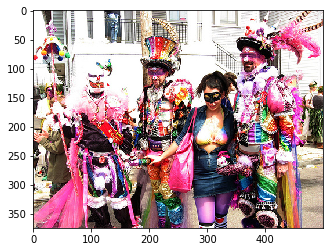

prediction: group of people are gathered in front of fruit
Ground Truth: group of people dressed up colorfully
Ground Truth: group of people stand while wearing bright and colorful costumes
Ground Truth: four people are standing in front of white building wearing colorful costumes
Ground Truth: people dressed in colorful mardis gras outfits pose very suggestively for the camera
Ground Truth: people in colorful costumes and masks


In [38]:
#OBSERVATION OF PERFORMANCE ON RANDOM IMAGES FROM DEV DATASET
key = list(dev_dataset.keys())[np.random.randint(0, 1000)]
print("model5")
print(key)
feature_vec = encoded_dev_images[key].reshape((1, 2048))
image_path = "../../../Downloads/Flickr8k/Flicker8k_dataset/"+key+".jpg"
image_ = plt.imread(image_path)
plt.imshow(image_)
plt.show()
print("prediction: {}".format(predict5(feature_vec)))
for caption in dev_dataset[key]:
    caption = ' '.join(caption.split()[1:-1])
    print("Ground Truth: {}".format(caption))

In [19]:
#PERFORMANCE ON TRAIN DATASET, DEV DATASET
batch_size = 3
steps = len(train_dataset)//batch_size
train_generator = data_generator(train_dataset, encoded_train_images, word_to_index, max_caption_length, batch_size)
train_performance = model5.evaluate(train_generator, steps=steps, verbose=0)

batch_size = 4
steps = len(dev_dataset)//batch_size
dev_generator = data_generator(dev_dataset, encoded_dev_images, word_to_index, max_caption_length, batch_size)
dev_performance = model5.evaluate(dev_generator, steps=steps, verbose=0)

print("LOSS ON TRAIN DATASET: {}".format(train_performance))
print("LOSS ON DEV DATASET: {}".format(dev_performance))

LOSS ON TRAIN DATASET: [2.3054563999176025, 0.45285776257514954]
LOSS ON DEV DATASET: [3.6810479164123535, 0.33071526885032654]


In [39]:
i=0
file = open("random_metrics.txt", "r")
content = file.read()
file.close()
lines = content.split("\n")

In [77]:
key = lines[i]
print("model5")
print(key)
feature_vec = encoded_dev_images[key].reshape((1, 2048))
image_path = "../../../Downloads/Flickr8k/Flicker8k_dataset/"+key+".jpg"
image_ = plt.imread(image_path)
plt.imshow(image_)
plt.show()
print("prediction: {}".format(predict5(feature_vec)))
for caption in dev_dataset[key]:
    caption = ' '.join(caption.split()[1:-1])
    print("Ground Truth: {}".format(caption))
i+=1

model5



KeyError: ''

wandb: ERROR Error uploading "model_2.h5": CommError, File /var/folders/p2/gvj_1k4118b9y6bc1zqpzc3h0000gn/T/tmpg_ku10a9wandb/2jmxrbmz-model_2.h5 size shrank from 19160428 to 2022764 while it was being uploaded.
